# Modelos

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
import scipy as sp
from statsmodels.graphics.gofplots import qqplot
from itertools import cycle, islice

In [35]:
df = pd.read_csv("data.csv")

In [36]:
# Codigo importado del notebook de analisis

interest_groups = df.columns[-10:-2]
continents = ["Africa", "Americas", "Asia", "Europe", "Oceania"]
regions = [name for name in df.columns[250:272] if name not in continents]
interest_groups_df = df[interest_groups]
continents_df = df[continents]
regions_df = df[regions]
world_lapse=df.copy()
interest_groups_df_lapse=interest_groups_df.copy()
continents_df_lapse=continents_df.copy()
regions_df_lapse=regions_df.copy()
dfs=[world_lapse,interest_groups_df_lapse,continents_df_lapse,regions_df_lapse]
def time_group(lapse,n):
    labels=[]
    for i in range(1,int(np.ceil(n/lapse))+1):
        labels.extend(np.ones(lapse).astype(int)*i)
    return labels[0:n]
for each_df in dfs:
    each_df['Trimester']=time_group(3,len(each_df))
    each_df['Semester']=time_group(6,len(each_df))
    each_df['Year']=time_group(12,len(each_df))
    each_df['Lustrum']=time_group(60,len(each_df))
    each_df['Decade']=time_group(120,len(each_df))
world_data={'Month':df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    world_data[time_interval]=(world_lapse.groupby(time_interval).mean())[world_lapse.columns[1:285]]

interest_groups_data={'Month':interest_groups_df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    interest_groups_data[time_interval]=(interest_groups_df_lapse.groupby(time_interval).mean())[interest_groups]
    
continents_data={'Month':continents_df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    continents_data[time_interval]=(continents_df_lapse.groupby(time_interval).mean())[continents]
    
regions_data={'Month':regions_df}
for time_interval in ['Trimester','Semester','Year','Lustrum','Decade']:
    regions_data[time_interval]=(regions_df_lapse.groupby(time_interval).mean())[regions]
    
grouped_data={'World':world_data,
            'Interest Groups':interest_groups_data,
            'Continents':continents_data,
            'Regions':regions_data}

## Datos a usar

In [37]:
data=pd.DataFrame(grouped_data['Continents']['Month']['Africa'])

## Division de muestras

In [38]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]
num_features = df.shape[1]

## Ventana de los datos

In [39]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
            train_df=train_df, val_df=val_df, test_df=test_df,
            label_columns=None):
    # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
    
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                enumerate(train_df.columns)}
    
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
    
        self.total_window_size = input_width + shift
    
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [40]:
forecast=12
w1 = WindowGenerator(input_width=len(train_df)-forecast, label_width=forecast, shift=12,
                        label_columns=['Africa'])
w1

Total window size: 495
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [41]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                    label_columns=['Africa'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Africa']

## Separacion de ventana en inputs y etiquetas

In [42]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

## Visualizacion de la ventana

In [43]:
def plot(self, model=None, plot_col='Africa', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
    
        if label_col_index is None:
            continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

    if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [44]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                        np.array(train_df[100:100+w2.total_window_size]),
                        np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


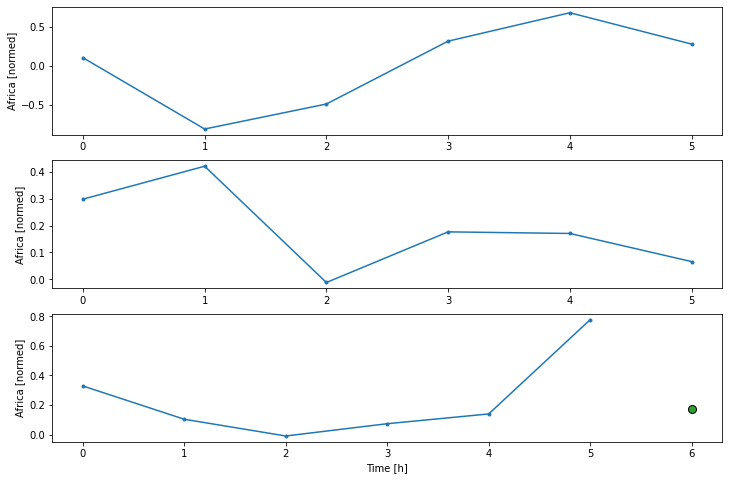

In [45]:
w2.example = example_inputs, example_labels
w2.plot()

In [46]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 495, 1)
Inputs shape: (1, 483, 1)
Labels shape: (1, 12, 1)


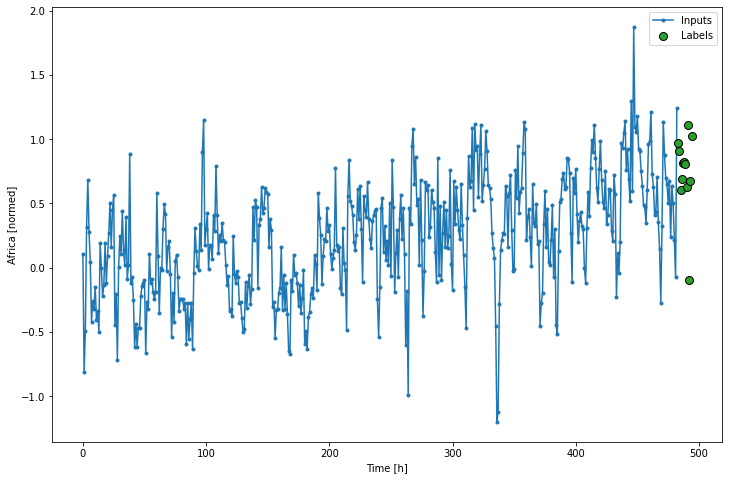

In [47]:
w1.example = example_inputs, example_labels
w1.plot()

## Se crea estructura de datos TF

In [48]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

## Se definen propiedades para acceder a TF

In [50]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [51]:
w1.train.element_spec

(TensorSpec(shape=(None, 483, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None))

## Ventana de un solo paso

In [52]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Africa'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Africa']

In [53]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                            np.array(train_df[100:100+w1.total_window_size]),
                            np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [495,1] != values[1].shape = [395,1] [Op:Pack] name: stack

In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
w1.plot()

## Modelo base

In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['Africa'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

## Ventana amplia

In [ ]:
wide_window = WindowGenerator(input_width=len(train_df), label_width=1, shift=12,
                    label_columns=['Africa'])
wide_window

In [ ]:
wide_window.plot(baseline)

## RNN

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

## CNN